### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from tensorflow.keras.layers import Normalization, Resizing, RandomWidth, RandomFlip, RandomRotation, RandomHeight, Rescaling, Input, Dropout, Dense
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2
import keras
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa

### Load CIFAR10 Dataset

In [2]:
# load dataset
def load_dataset():
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    return trainX,trainY,testX,testY

In [3]:
trainX,trainY,testX, testY=load_dataset()

170508288/170498071 [==============================] - 4s 0us/step


In [4]:
print(trainX.shape)

(50000, 32, 32, 3)


### Data Augmentation Model

In [5]:
model_data_augmentation = Sequential()
model_data_augmentation.add(Rescaling(1.0/255))
model_data_augmentation.add(RandomWidth((0.2)))
model_data_augmentation.add(RandomFlip("horizontal"))
model_data_augmentation.add(RandomRotation((-0.01,0.01)))
model_data_augmentation.add(RandomHeight(0.2))
model_data_augmentation.add(Resizing(32,32))

2022-05-03 17:16:42.288823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 17:16:42.407063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 17:16:42.407847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 17:16:42.409163: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
model_data_augmentation.build(input_shape=(32,32,3))
model_data_augmentation.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (32, 32, 3)               0         
_________________________________________________________________
random_width (RandomWidth)   (32, None, 3)             0         
_________________________________________________________________
random_flip (RandomFlip)     (32, None, 3)             0         
_________________________________________________________________
random_rotation (RandomRotat (32, None, 3)             0         
_________________________________________________________________
random_height (RandomHeight) (None, None, 3)           0         
_________________________________________________________________
resizing (Resizing)          (32, 32, 3)               0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
______________________________________________________________

In [7]:
augmented_images = model_data_augmentation(trainX)

In [8]:
aug_test=model_data_augmentation(testX)

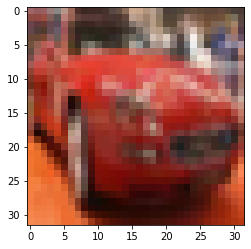

In [9]:
plt.imshow(trainX[5])

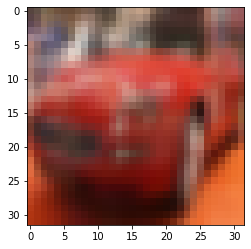

In [10]:
plt.imshow(augmented_images[5])

In [11]:
input_shape=(augmented_images.shape)

In [12]:
print(input_shape)

(50000, 32, 32, 3)


### Helper Functions

In [13]:
def plot_metric(model, metric):
    train_metrics = model.history[metric]
    val_metrics = model.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Train & Val '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [14]:
def plot_metric_mult(models, metric, labels):
    train_metrics = []
    for model in models:
        train_metrics.append(model.history[metric])
    epochs = range(1, len(train_metrics[0]) + 1)
    for train_metric in train_metrics:
        plt.plot(epochs, train_metric)
    plt.title('Train '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(labels)
    plt.show()

### ResNet50V2 Encoder Model Import

In [15]:
batch_size = 256
epochs = 50
val_split = 0.2

In [16]:
def create_encoder():
    resnet_model=ResNet50V2(include_top=False, weights=None, input_shape=(32, 32, 3), pooling='avg')
    model=Sequential(name = 'ResNet_Model_50')
    model.add(resnet_model)
    model.build(input_shape=input_shape)
    return model

In [17]:
def create_encoder_101():
    resnet_model=ResNet101V2(include_top=False, weights=None, input_shape=(32, 32, 3), pooling='avg')
    model=Sequential(name = 'ResNet_Model_101')
    model.add(resnet_model)
    model.build(input_shape=input_shape)
    return model

### Classification Model Built on top of ResNet50

In [18]:
def define_model(encoder, model_name, optimizer_val):
    model=Sequential(name = model_name)
    model.add(encoder)
    model.add(Dropout(0.5))
    model.add(Dense(512,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer=optimizer_val, loss='sparse_categorical_crossentropy',metrics=["sparse_categorical_accuracy"])
    return model

In [19]:
encoder_resnet = create_encoder()
for layer in encoder_resnet.layers:
    layer.trainable = True
encoder_resnet.summary()
model_cel = define_model(encoder_resnet,'Classification_Model_CrossEntropy','adam')
model_cel.summary()

Model: "ResNet_Model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________
Model: "Classification_Model_CrossEntropy"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet_Model_50 (Sequential) (None, 2048)              23564800  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0 

In [20]:
history_cel = model_cel.fit(augmented_images, trainY, batch_size=batch_size, epochs=epochs, validation_split=val_split, verbose=1)

2022-05-03 17:16:50.708763: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-03 17:16:55.892863: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


157/157 [==============================] - 25s 82ms/step - loss: 1.9223 - sparse_categorical_accuracy: 0.3031 - val_loss: 3.1062 - val_sparse_categorical_accuracy: 0.1604
Epoch 2/50
157/157 [==============================] - 11s 72ms/step - loss: 1.4855 - sparse_categorical_accuracy: 0.4703 - val_loss: 2.8865 - val_sparse_categorical_accuracy: 0.2102
Epoch 3/50
157/157 [==============================] - 12s 75ms/step - loss: 1.3900 - sparse_categorical_accuracy: 0.5053 - val_loss: 2.1447 - val_sparse_categorical_accuracy: 0.3045
Epoch 4/50
157/157 [==============================] - 11s 72ms/step - loss: 1.2112 - sparse_categorical_accuracy: 0.5747 - val_loss: 1.7580 - val_sparse_categorical_accuracy: 0.4380
Epoch 5/50
157/157 [==============================] - 11s 73ms/step - loss: 1.0878 - sparse_categorical_accuracy: 0.6234 - val_loss: 1.4387 - val_sparse_categorical_accuracy: 0.5202
Epoch 6/50
157/157 [==============================] - 11s 73ms/step - loss: 1.0310 - sparse_categoric

In [21]:
model_cel.evaluate(aug_test,testY)

313/313 [==============================] - 4s 14ms/step - loss: 1.8450 - sparse_categorical_accuracy: 0.6707


[1.8449790477752686, 0.6707000136375427]

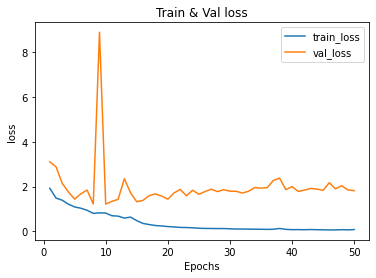

In [22]:
plot_metric(history_cel,'loss')

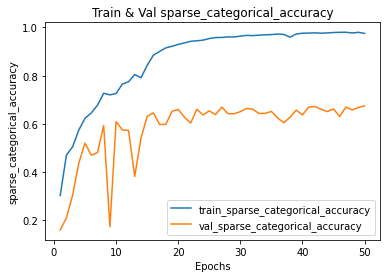

In [23]:
plot_metric(history_cel,'sparse_categorical_accuracy')

### Supervised Contrastive Loss Section

#### Create Keras compatible Supervised Contrastive Loss Function Below

In [24]:
class supervised_contrastive_loss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(supervised_contrastive_loss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

### Add Projection Network

In [25]:
def Map_Repr_Proj(encoder,optimizer_val):
    model_map = Sequential(name = 'Projection_Model')
    model_map.add(encoder)
    model_map.add(Dense(128, activation="relu"))
    model_map.compile(optimizer=optimizer_val,loss=supervised_contrastive_loss(0.1),metrics=['accuracy'])
    return model_map
    

#### Train only the encoder Model with augmented images below

In [26]:
def train_encoder(encoder_type=1,optimizer='adam'):
    if encoder_type == 1:
        encoder_model = create_encoder()
    elif encoder_type == 2:
        encoder_model = create_encoder_101()
    for layer in encoder_model.layers:
        layer.trainable = True
    encoder_map=Map_Repr_Proj(encoder_model,optimizer)
    encoder_map.summary()
    history_map = encoder_map.fit(augmented_images,trainY,batch_size=batch_size, epochs=epochs, verbose=1)
    return encoder_model

In [27]:
encoder_model_50 = train_encoder()

Model: "Projection_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet_Model_50 (Sequential) (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
Total params: 23,827,072
Trainable params: 23,781,632
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 18s 71ms/step - loss: 5.2433 - accuracy: 0.0223
Epoch 2/50
196/196 [==============================] - 13s 67ms/step - loss: 5.0268 - accuracy: 0.0193
Epoch 3/50
196/196 [==============================] - 13s 67ms/step - loss: 4.8738 - accuracy: 0.0190
Epoch 4/50
196/196 [==============================] - 13s 67ms/step - loss: 4.7419 - accuracy: 0.0223
Epoch 5/50
196/196 [==============================] - 13s 69ms/step - loss: 4.6183 - ac

#### Train the classification model but freeze the encoder model below

In [28]:
def train_classifier(encoder_model,optimizer='adam'):
    for layer in encoder_model.layers:
        layer.trainable = False
    model_scl = define_model(encoder_model, 'Supervised_Contrastive_Model',optimizer)
    model_scl.summary()
    history_scl = model_scl.fit(augmented_images, trainY, batch_size=batch_size, epochs=epochs, validation_split=val_split, verbose=1)
    return model_scl, history_scl

In [29]:
model_scl, history_scl = train_classifier(encoder_model_50)

Model: "Supervised_Contrastive_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet_Model_50 (Sequential) (None, 2048)              23564800  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 24,619,018
Trainable params: 1,054,218
Non-trainable params: 23,564,800
_________________________________________________________________
Epoch 1/50
157/157 [==============================] - 8s 34ms/step - loss: 0.2323 - 

In [30]:
model_scl.evaluate(aug_test,testY)

313/313 [==============================] - 5s 15ms/step - loss: 1.5140 - sparse_categorical_accuracy: 0.7062


[1.514035701751709, 0.7062000036239624]

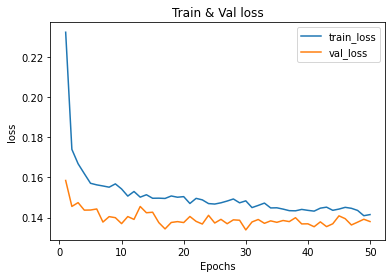

In [31]:
plot_metric(history_scl,'loss')

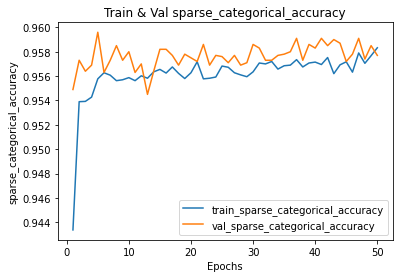

In [32]:
plot_metric(history_scl,'sparse_categorical_accuracy')

### Using on ResNet101V2 as Encoder

In [33]:
encoder_model_101 = train_encoder(encoder_type=2)

Model: "Projection_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet_Model_101 (Sequential (None, 2048)              42626560  
_________________________________________________________________
dense_5 (Dense)              (None, 128)               262272    
Total params: 42,888,832
Trainable params: 42,791,168
Non-trainable params: 97,664
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 32s 119ms/step - loss: 5.2587 - accuracy: 1.2000e-04
Epoch 2/50
196/196 [==============================] - 23s 119ms/step - loss: 5.0567 - accuracy: 5.4000e-04
Epoch 3/50
196/196 [==============================] - 24s 121ms/step - loss: 4.9245 - accuracy: 5.0000e-04
Epoch 4/50
196/196 [==============================] - 23s 119ms/step - loss: 4.8069 - accuracy: 4.0000e-05
Epoch 5/50
196/196 [==============================] - 23s 118ms/ste

In [34]:
model_scl_101, history_scl_101 = train_classifier(encoder_model_101)

Model: "Supervised_Contrastive_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet_Model_101 (Sequential (None, 2048)              42626560  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 43,680,778
Trainable params: 1,054,218
Non-trainable params: 42,626,560
_________________________________________________________________
Epoch 1/50
157/157 [==============================] - 14s 59ms/step - loss: 0.3421 -

In [35]:
model_scl_101.evaluate(aug_test,testY)

313/313 [==============================] - 8s 27ms/step - loss: 1.4403 - sparse_categorical_accuracy: 0.6870


[1.4403364658355713, 0.6869999766349792]

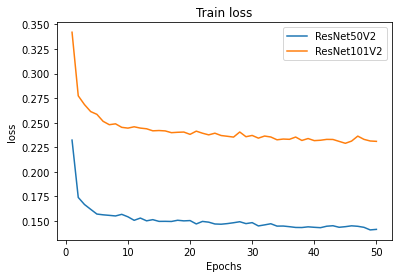

In [36]:
plot_metric_mult([history_scl,history_scl_101],'loss',['ResNet50V2','ResNet101V2'])

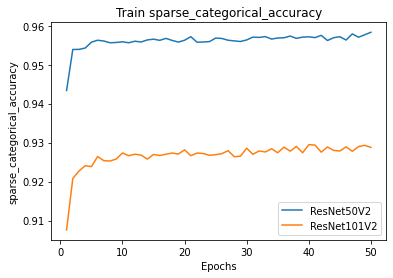

In [37]:
plot_metric_mult([history_scl,history_scl_101],'sparse_categorical_accuracy',['ResNet50V2','ResNet101V2'])

### Hyperparameter Tunning

In [38]:
optimizers = ['adam','sgd','RMSprop']

In [39]:
model_hist_list = []
for val in optimizers:
    encoder_model_opt = train_encoder(optimizer=val)
    model_scl_opt, history_scl_opt = train_classifier(encoder_model_opt)
    model_hist_list.append(history_scl_opt)

Model: "Projection_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet_Model_50 (Sequential) (None, 2048)              23564800  
_________________________________________________________________
dense_8 (Dense)              (None, 128)               262272    
Total params: 23,827,072
Trainable params: 23,781,632
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 18s 68ms/step - loss: 5.2390 - accuracy: 0.0012
Epoch 2/50
196/196 [==============================] - 13s 68ms/step - loss: 5.0238 - accuracy: 0.0019
Epoch 3/50
196/196 [==============================] - 13s 69ms/step - loss: 4.8803 - accuracy: 0.0027
Epoch 4/50
196/196 [==============================] - 13s 68ms/step - loss: 4.7491 - accuracy: 0.0025
Epoch 5/50
196/196 [==============================] - 13s 68ms/step - loss: 4.6308 - ac

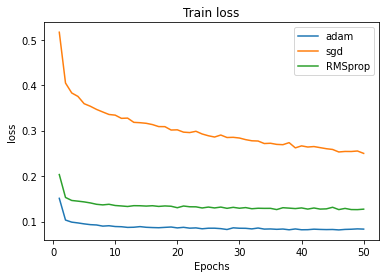

In [40]:
plot_metric_mult(model_hist_list,'loss',optimizers)

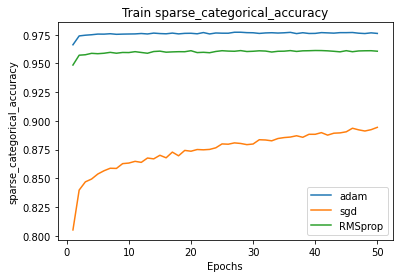

In [41]:
plot_metric_mult(model_hist_list,'sparse_categorical_accuracy',optimizers)

### Embeddings Visualization

In [42]:
from sklearn.decomposition import PCA

scl_embeddings = encoder_model_50.predict(augmented_images)
cle_embeddings = encoder_resnet.predict(augmented_images)

pca = PCA(n_components=2)
scl_embeddings_compressed = pca.fit_transform(scl_embeddings)
cle_embeddings_compressed = pca.fit_transform(cle_embeddings)

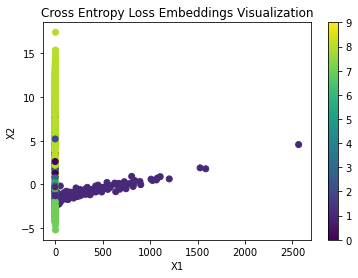

In [43]:
scatter = plt.scatter(cle_embeddings_compressed[:,0],cle_embeddings_compressed[:,1],c=trainY)
plt.xlabel('X1')
plt.ylabel('X2')
plt.colorbar(scatter)
plt.title("Cross Entropy Loss Embeddings Visualization")
plt.show()

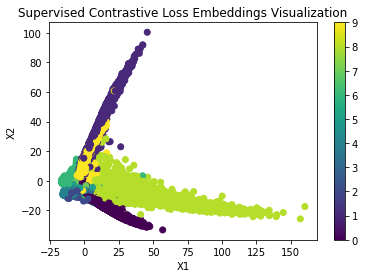

In [44]:
scatter = plt.scatter(scl_embeddings_compressed[:,0],scl_embeddings_compressed[:,1],c=trainY)
plt.xlabel('X1')
plt.ylabel('X2')
plt.colorbar(scatter)
plt.title("Supervised Contrastive Loss Embeddings Visualization")
plt.show()

It is expected that the embedding trained using supervised contrastive learning will be much more clustered than the embedding trained using regular cross-entropy since the supervised contrastive learning rewards the model from pushing apart instances from different classes. 